# Evaluation - Produce AFL-Pathcoverage &  
# Unique AFL-Crashes

In [77]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [78]:
def convert_unixtime_deltaseconds(df, unix=True, timecolumn='# unix_time'):
    if unix:
        df['date'] = pd.to_datetime(df[timecolumn],unit='s')
    else:
        df['date'] = pd.to_datetime(df[timecolumn])
        
    #df['date'] = df['date'].dt.round('1s')
    return df

#https://stackoverflow.com/questions/25234941/python-regularise-irregular-time-series-with-linear-interpolation
def resample_timeseries(df, resample_freq, resample_col, time_series_col='date', path=True):
    df_ = df[[time_series_col, resample_col]]
    
    if path:
        start_index = 0
    else:
        start_index = 1
        
    df_ = df_.append({time_series_col: df_[time_series_col].iloc[start_index] + pd.Timedelta(hours=24)}, ignore_index=True)
    df_[resample_col] = df_[resample_col].ffill()

    df_ = df_[~df_[time_series_col].duplicated()]
    df_ = df_.set_index(time_series_col).resample('s').interpolate().resample(resample_freq).asfreq().fillna(0)
    df_ = df_.reset_index()
    
    df_['delta_time'] = df_[time_series_col] - df_[time_series_col].iloc[start_index]
    df_['delta_time'] = df_['delta_time'].apply(lambda x: pd.Timedelta(0.0) if x.total_seconds() < 0.0 else x)
    return df_

def utest(dffinal, x_var='delta_time', y_var='cur_path', event1='AFL', event2='Curious_AFL'):
    dffinal2 = dffinal.groupby([x_var, 'event']).mean().reset_index()
    dffinal2_afl = dffinal2.loc[dffinal2['event']==event1][y_var]
    dffinal2_curious = dffinal2.loc[dffinal2['event']==event2][y_var]
    stat, p = mannwhitneyu(dffinal2_afl, dffinal2_curious)
    return np.round(p, 6)

In [79]:
def df_plotdata_resample(df, event, field, rename_field):
    df = convert_unixtime_deltaseconds(df)
    df_ = resample_timeseries(df, '15T', field)
    
    #df = df[['delta_time', field]]
    df_ = df_.rename(columns={field: rename_field})
    #df_ = pd.concat([pd.DataFrame({'date': df['date'].iloc[0], rename_field: 0}), df_]).reset_index() 
    #df[rename_field] =df[rename_field].ffill()
    df_['event'] = event
    return df_

def df_coverage_resample(df, event, field='total_coverage_own_finds', rename_field='cur_path'):
    df = convert_unixtime_deltaseconds(df,unix=False, timecolumn='m_timestamp')
    #df = df[['total_coverage_own_finds', 'delta_time']]
    df = resample_timeseries(df, '15T', field, time_series_col='date', path=True)

    df = df[['delta_time', 'total_coverage_own_finds']]
    df = df.rename(columns={field: rename_field})
    #df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = event
    return df

In [80]:
resultspath = '../results/'
sns.set(rc={'figure.figsize':(11.7,8.27)})

## path-coverages

In [81]:
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame(),
    'mupdf': pd.DataFrame(),
    'harfbuzz': pd.DataFrame(),
    'gif2png': pd.DataFrame(),
    'size': pd.DataFrame(),
    'readelf': pd.DataFrame()
}
empty_seed = False

In [82]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:    
        for trial in range(1,11):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'CuriousAFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Curious file not available: ' + exec_name + ' trial: ' + str(trial))

            
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

Curious file not available: objdump trial: 2
Curious file not available: nm trial: 2
Curious file not available: ffmpeg trial: 2
AFL file not available: mupdf trial: 6
AFL Fast file not available: mupdf trial: 6
Curious file not available: mupdf trial: 3
AFL file not available: harfbuzz trial: 6
AFL Fast file not available: harfbuzz trial: 6
Curious file not available: harfbuzz trial: 2
AFL file not available: gif2png trial: 6
AFL Fast file not available: gif2png trial: 6
Curious file not available: gif2png trial: 2
AFL file not available: size trial: 6
AFL Fast file not available: size trial: 6
Curious file not available: size trial: 2
AFL file not available: readelf trial: 3
AFL Fast file not available: readelf trial: 3
Curious file not available: readelf trial: 2


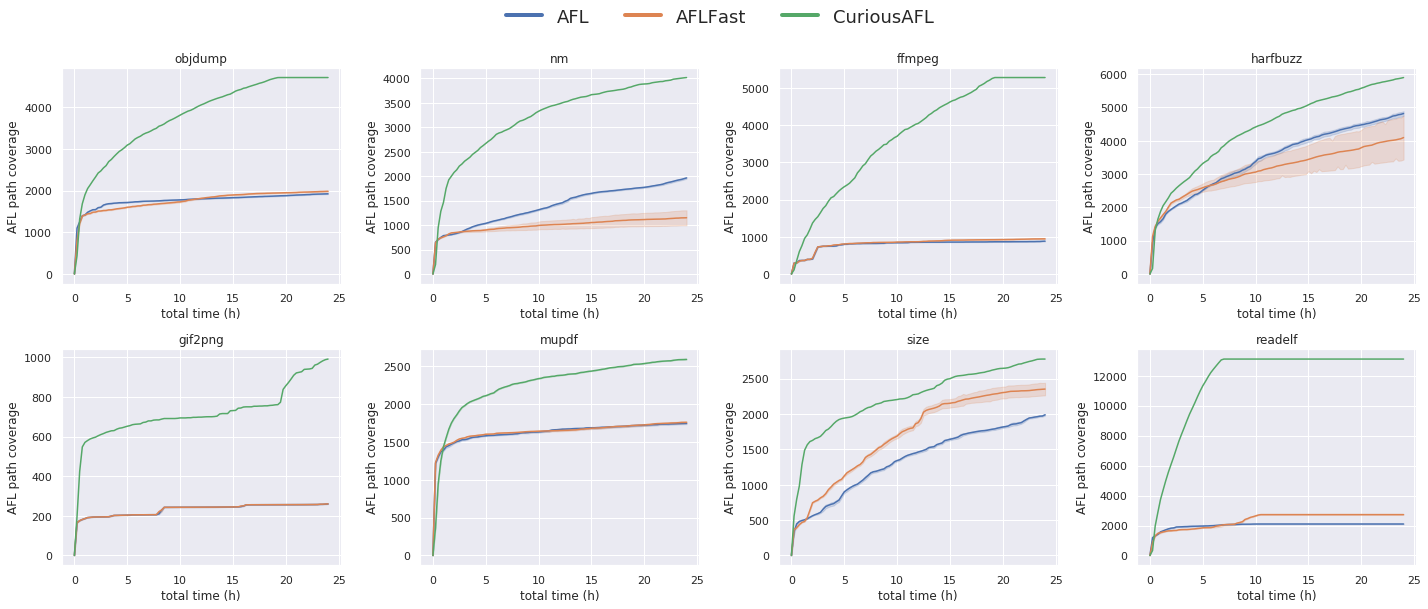

In [83]:
if empty_seed:
    seed='emptyseed'
else:
    seed='premadeseed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax1, legend=False, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax1.legend()
ax1.title.set_text('objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

ax2 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax2,legend=False, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax2.legend()
ax2.title.set_text('nm')

ax3 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax3,legend=False, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax3.legend()
ax3.title.set_text('ffmpeg')

ax4 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax4,legend=False, data=results['harfbuzz'])
ax4.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax4.legend()
ax4.title.set_text('harfbuzz')

ax5 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax5,legend=False, data=results['gif2png'])
ax5.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax5.legend()
ax5.title.set_text('gif2png')

ax6 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
ax6.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax6.legend()
ax6.title.set_text('mupdf')

ax7 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax7,legend=False, data=results['size'])
ax7.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax7.legend()
ax7.title.set_text('size')

ax8 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax8, data=results['readelf'])
ax8.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax8.legend()
ax8.title.set_text('readelf')

handles, labels = ax8.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
#plt.ylabel("afl path coverage")
leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=3, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax8.get_legend().remove()
#if empty_seed:
#    fig.suptitle('Path coverage with Empty Seed')
#else:
#    fig.suptitle('Path coverage with Premade Seed')
    
fig.tight_layout() #rrect=[0,0,1,1]

#fig.subplots_adjust(top=0.88)
plt.savefig('./graphs/24h_pathcoverage_'+ seed + '.png', dpi = 200, bbox_inches="tight")
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

## Unique-crashes

In [84]:
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame(),
    'mupdf': pd.DataFrame(),
    'harfbuzz': pd.DataFrame(),
    'gif2png': pd.DataFrame(),
    'size': pd.DataFrame(),
    'readelf': pd.DataFrame()
}
empty_seed = False

In [85]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:
        for trial in range(1,11):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'CuriousAFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Curious file not available: ' + exec_name + ' trial: ' + str(trial))

        
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

Curious file not available: objdump trial: 2
Curious file not available: nm trial: 2
Curious file not available: ffmpeg trial: 2
AFL file not available: mupdf trial: 6
AFL Fast file not available: mupdf trial: 6
Curious file not available: mupdf trial: 3
AFL file not available: harfbuzz trial: 6
AFL Fast file not available: harfbuzz trial: 6
Curious file not available: harfbuzz trial: 2
AFL file not available: gif2png trial: 6
AFL Fast file not available: gif2png trial: 6
Curious file not available: gif2png trial: 2
AFL file not available: size trial: 6
AFL Fast file not available: size trial: 6
Curious file not available: size trial: 2
AFL file not available: readelf trial: 3
AFL Fast file not available: readelf trial: 3
Curious file not available: readelf trial: 2


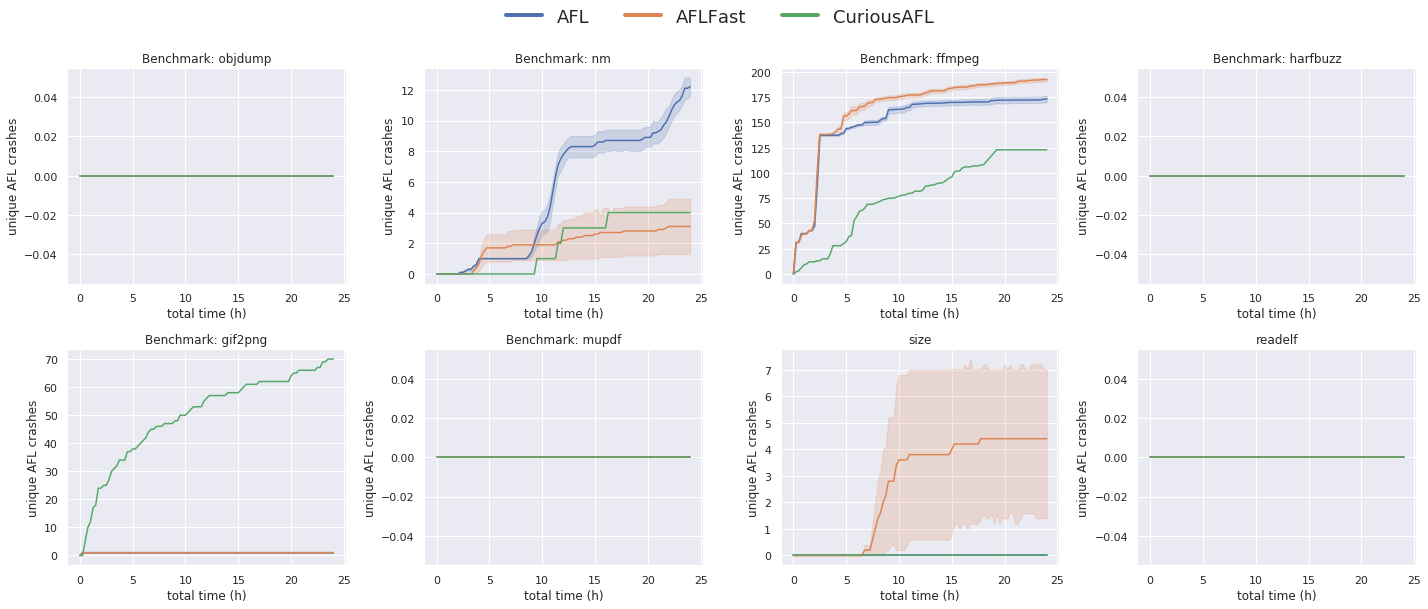

In [86]:
if empty_seed:
    seed='emptyseed'
else:
    seed='premadeseed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
#fig = plt.figure()
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)

ax1 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False,ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax1.legend()
ax1.title.set_text('Benchmark: ' + 'objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

ax2 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, legend=False,ax=ax2, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax2.legend()
ax2.title.set_text('Benchmark: ' + 'nm')

ax3 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False, ax=ax3, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax3.legend()
ax3.title.set_text('Benchmark: ' + 'ffmpeg')

ax4 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False, ax=ax4, data=results['harfbuzz'])
ax4.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax4.legend()
ax4.title.set_text('Benchmark: ' + 'harfbuzz')

ax5 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False, ax=ax5, data=results['gif2png'])
ax5.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax5.legend()
ax5.title.set_text('Benchmark: ' + 'gif2png')

ax6 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
ax6.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax6.legend()
ax6.title.set_text('Benchmark: ' + 'mupdf')

ax7 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax7,legend=False, data=results['size'])
ax7.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax7.legend()
ax7.title.set_text('size')

ax8 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax8, data=results['readelf'])
ax8.set(xlabel='total time (h)', ylabel='unique AFL crashes')
#ax8.legend()
ax8.title.set_text('readelf')


handles, labels = ax8.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
#plt.ylabel("afl path coverage")
leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=3, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax8.get_legend().remove()

#plt.ylabel("afl path coverage")
#plt.ylabel("afl path coverage")
#if empty_seed:
#    fig.suptitle('Unique AFL-Crashes with Empty Seed')
#else:
#    fig.suptitle('Unique AFL-Crashes with Premade Seed')
    
fig.tight_layout()
#fig.subplots_adjust(top=0.88)
plt.savefig('./graphs/24h_crashes_'+ seed + '.png', dpi = 200, bbox_inches="tight")
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

# Case study  
## Coverage per case

In [88]:
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    #'ffmpeg': pd.DataFrame(),
    #'mupdf': pd.DataFrame(),
    #'harfbuzz': pd.DataFrame(),
    #'gif2png': pd.DataFrame(),
    #'size': pd.DataFrame(),
    #'readelf': pd.DataFrame()
}
empty_seed = False

In [89]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:    
        for trial in range(1,11):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'faster' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'Faster', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Faster file not available: ' + exec_name + ' trial: ' + str(trial))
    
    try:    
        for trial in range(1,11):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'fasterrandom' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'FasterRandom', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('FasterRandom file not available: ' + exec_name + ' trial: ' + str(trial))
            
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

Faster file not available: objdump trial: 4
FasterRandom file not available: objdump trial: 4
Faster file not available: nm trial: 3
FasterRandom file not available: nm trial: 3


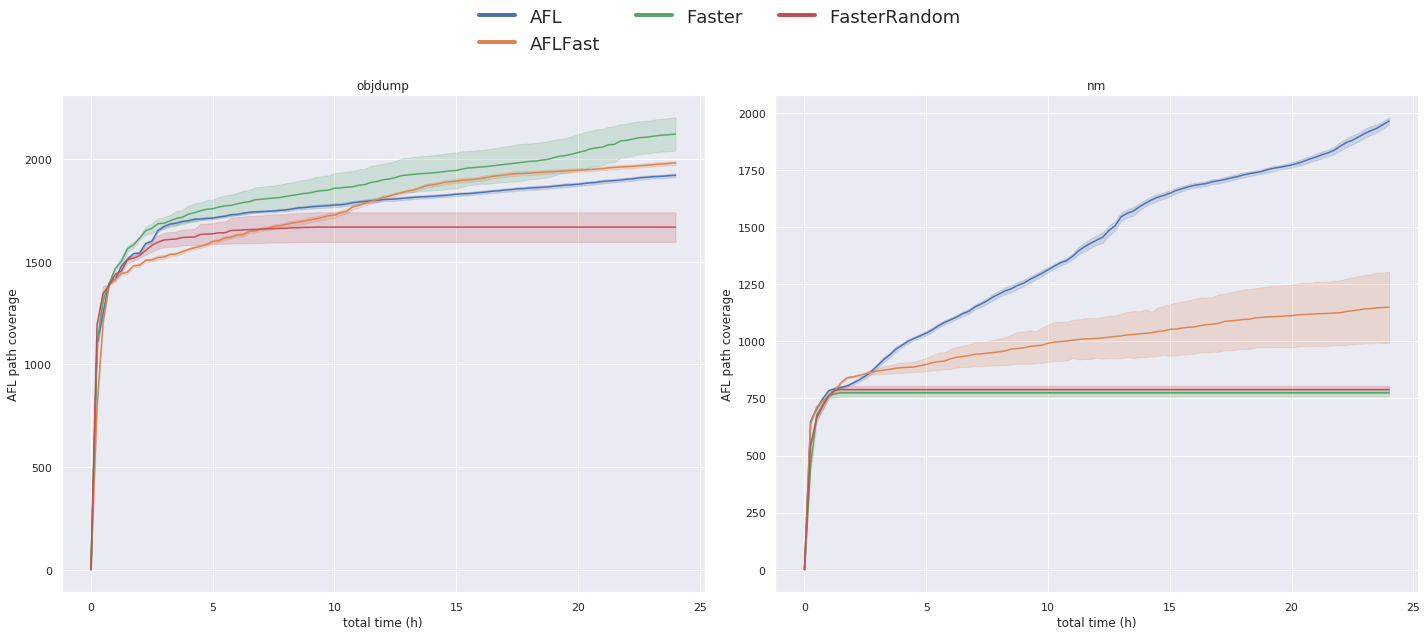

In [90]:
if empty_seed:
    seed='emptyseed'
else:
    seed='premadeseed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#ax3 = fig.add_subplot(243)
#ax4 = fig.add_subplot(244)
#ax5 = fig.add_subplot(245)
#ax6 = fig.add_subplot(246)
#ax7 = fig.add_subplot(247)
#ax8 = fig.add_subplot(248)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax1.legend()
ax1.title.set_text('objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)


ax2 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax2,legend=False, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax2.legend()
ax2.title.set_text('nm')
    
if False:
    

    ax3 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax3,legend=False, data=results['ffmpeg'])
    ax3.set(xlabel='total time (h)', ylabel='AFL path coverage')
    #ax3.legend()
    ax3.title.set_text('ffmpeg')

    ax4 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax4,legend=False, data=results['harfbuzz'])
    ax4.set(xlabel='total time (h)', ylabel='AFL path coverage')
    #ax4.legend()
    ax4.title.set_text('harfbuzz')

    ax5 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax5,legend=False, data=results['gif2png'])
    ax5.set(xlabel='total time (h)', ylabel='AFL path coverage')
    #ax5.legend()
    ax5.title.set_text('gif2png')

    ax6 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
    ax6.set(xlabel='total time (h)', ylabel='AFL path coverage')
    #ax6.legend()
    ax6.title.set_text('mupdf')

    ax7 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax7,legend=False, data=results['size'])
    ax7.set(xlabel='total time (h)', ylabel='AFL path coverage')
    #ax7.legend()
    ax7.title.set_text('size')

    ax8 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax8, data=results['readelf'])
    ax8.set(xlabel='total time (h)', ylabel='AFL path coverage')
    #ax8.legend()
    ax8.title.set_text('readelf')

handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
#plt.ylabel("afl path coverage")
leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=3, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax1.get_legend().remove()
#if empty_seed:
#    fig.suptitle('Path coverage with Empty Seed')
#else:
#    fig.suptitle('Path coverage with Premade Seed')
    
fig.tight_layout() #rrect=[0,0,1,1]

#fig.subplots_adjust(top=0.88)
plt.savefig('./graphs/testcase_casecuriosity_'+ seed + '.png', dpi = 200, bbox_inches="tight")
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

## Coverage per mutation

In [91]:
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame(),
    'mupdf': pd.DataFrame(),
    'harfbuzz': pd.DataFrame(),
    'gif2png': pd.DataFrame(),
    'size': pd.DataFrame(),
    'readelf': pd.DataFrame()
}
empty_seed = False

In [92]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:    
        for trial in range(1,11):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,11):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'CuriousAFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Curious file not available: ' + exec_name + ' trial: ' + str(trial))
    
    try:    
        for trial in range(1,11):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'Random', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Random file not available: ' + exec_name + ' trial: ' + str(trial))

            
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

Curious file not available: objdump trial: 2
Random file not available: objdump trial: 6
Curious file not available: nm trial: 2
Random file not available: nm trial: 3
Curious file not available: ffmpeg trial: 2
Random file not available: ffmpeg trial: 1
AFL file not available: mupdf trial: 6
AFL Fast file not available: mupdf trial: 6
Curious file not available: mupdf trial: 3
Random file not available: mupdf trial: 1
AFL file not available: harfbuzz trial: 6
AFL Fast file not available: harfbuzz trial: 6
Curious file not available: harfbuzz trial: 2
Random file not available: harfbuzz trial: 1
AFL file not available: gif2png trial: 6
AFL Fast file not available: gif2png trial: 6
Curious file not available: gif2png trial: 2
Random file not available: gif2png trial: 4
AFL file not available: size trial: 6
AFL Fast file not available: size trial: 6
Curious file not available: size trial: 2
Random file not available: size trial: 1
AFL file not available: readelf trial: 3
AFL Fast file no

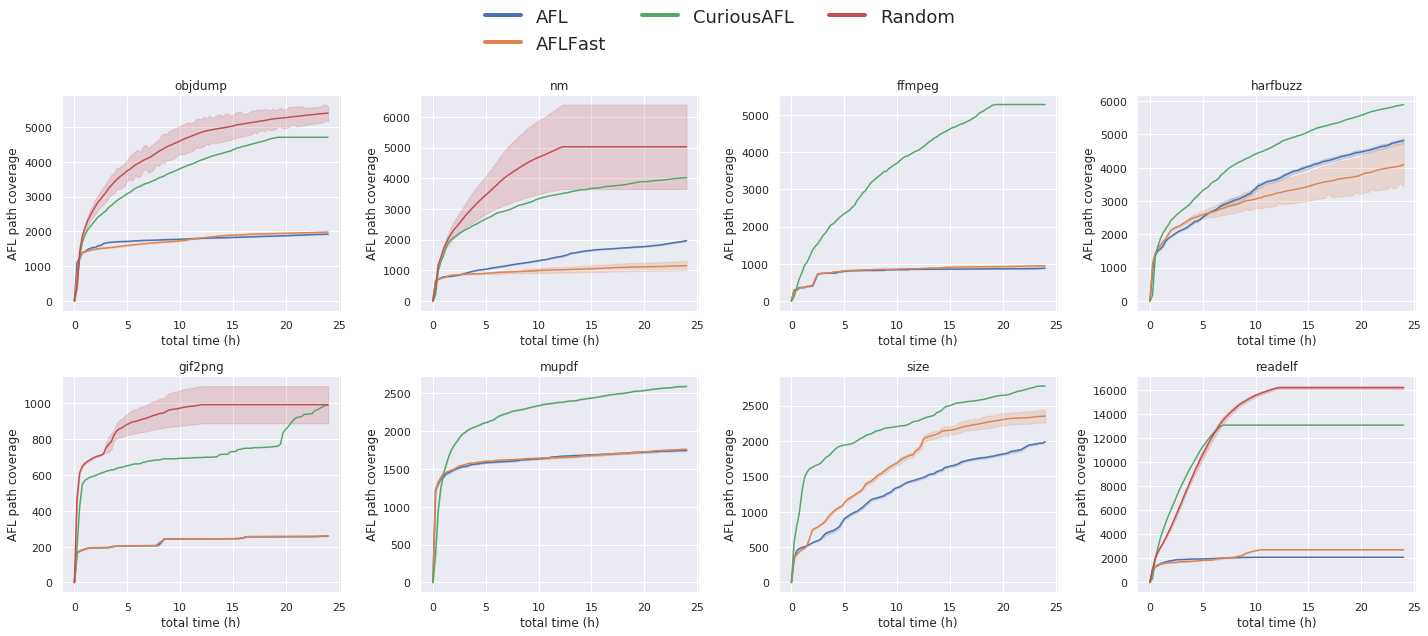

In [93]:
if empty_seed:
    seed='emptyseed'
else:
    seed='premadeseed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax1.legend()
ax1.title.set_text('objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

ax2 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax2,legend=False, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax2.legend()
ax2.title.set_text('nm')

ax3 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax3,legend=False, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax3.legend()
ax3.title.set_text('ffmpeg')

ax4 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax4,legend=False, data=results['harfbuzz'])
ax4.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax4.legend()
ax4.title.set_text('harfbuzz')

ax5 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax5,legend=False, data=results['gif2png'])
ax5.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax5.legend()
ax5.title.set_text('gif2png')

ax6 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
ax6.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax6.legend()
ax6.title.set_text('mupdf')

ax7 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax7,legend=False, data=results['size'])
ax7.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax7.legend()
ax7.title.set_text('size')

ax8 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax8,legend=False, data=results['readelf'])
ax8.set(xlabel='total time (h)', ylabel='AFL path coverage')
#ax8.legend()
ax8.title.set_text('readelf')

handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
#plt.ylabel("afl path coverage")
leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=3, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax1.get_legend().remove()
#if empty_seed:
#    fig.suptitle('Path coverage with Empty Seed')
#else:
#    fig.suptitle('Path coverage with Premade Seed')
    
fig.tight_layout() #rrect=[0,0,1,1]

#fig.subplots_adjust(top=0.88)
plt.savefig('./graphs/testcase_mutationcuriosity_'+ seed + '.png', dpi = 200, bbox_inches="tight")
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)